In [ ]:
### Analyse des évolutions du DVF

In [3]:
# Importations des modules (library)
import pandas as pd # pip install pandas
import gc
import requests # pip install requests
import json

In [4]:
### Fonctions
def create_dvf_secondaires(dvf): # Creer les dvf secondaires permettant de faire toutes les analyses possibles sur le dvf d'un departement
    # dvf_natureculture contient les données des "nature_culture" (vergers, sols, futais ...) par id_mutation et id_parcelle.
    dvf_natureculture = dvf.drop(columns=['date_mutation', 'nature_mutation', 'valeur_fonciere',
           'adresse_numero', 'adresse_nom_voie',
           'code_commune', 'nom_commune', 'code_departement', 'type_local', 'surface_reelle_bati',
           'nombre_pieces_principales', 'longitude', 'latitude','annee','mois']).dropna(subset=['nature_culture']).drop_duplicates()
    dvf_natureculture_Total_surface_terrain = dvf_natureculture.groupby(["id_mutation"])["surface_terrain"].sum().to_frame().reset_index().rename(columns={"surface_terrain":"Total_surface_terrain"})
    
    # dvf_typelocal contient les données des "type local" (Maisons, Appartements, dépendances ou locaux) par id_mutation et id_parcelle.
    dvf_typelocal = dvf.drop(columns=['date_mutation', 'nature_mutation', 'valeur_fonciere',
           'adresse_numero', 'adresse_nom_voie',
           'code_commune', 'nom_commune', 'code_departement', 'nature_culture',
           'surface_terrain', 'longitude', 'latitude','annee','mois']).dropna(subset=['type_local']).drop_duplicates()
    
    # Creation des colonnes pour la gestion des type_local
    dvf_typelocal_Total_surface_reelle_bati = dvf_typelocal.groupby(["id_mutation"])["surface_reelle_bati"].sum().to_frame().reset_index().rename(columns={"surface_reelle_bati":"Total_surface_reelle_bati"})
    dvf_typelocal_Total_nombre_pieces_principales = dvf_typelocal.groupby(["id_mutation"])["nombre_pieces_principales"].sum().to_frame().reset_index().rename(columns={"nombre_pieces_principales":"Total_nombre_pieces_principales"})
    tcd_typelocal = pd.pivot_table(dvf_typelocal, values='surface_reelle_bati',index=['id_mutation'],columns='type_local',aggfunc={'surface_reelle_bati': 'count'}, fill_value=0).reset_index().rename(columns={"Appartement":"Nombre_Appartement","Dépendance":"Nombre_Dépendance","Local industriel. commercial ou assimilé":"Nombre_Local industriel. commercial ou assimilé","Maison":"Nombre_Maison"})
    dvf_typelocal_final = tcd_typelocal.merge(dvf_typelocal_Total_surface_reelle_bati,how='left',on=['id_mutation']).merge(dvf_typelocal_Total_nombre_pieces_principales,how='left',on=['id_mutation'])
    del dvf_typelocal_Total_surface_reelle_bati ; del dvf_typelocal_Total_nombre_pieces_principales ; del tcd_typelocal ; gc.collect
    
    # Globalise dvf_typelocal_final & dvf_natureculture_Total_surface_terrain
    dvf_typelocal_final = pd.merge(dvf_typelocal_final, dvf_natureculture_Total_surface_terrain, on=['id_mutation'], how='left')
    del dvf_natureculture_Total_surface_terrain ; gc.collect()
    
    #dvf_id contient les informations génériques (Valeur foncière, nature mutation,date mutation, adresse, commune, departement, localisation) par id_mutation
    dvf_temp = dvf.drop(columns=['type_local', 'surface_reelle_bati',
           'nombre_pieces_principales', 'nature_culture','surface_terrain']).dropna(subset=['adresse_nom_voie']).drop_duplicates(subset=['id_mutation'], keep='first')
    dvf_id = pd.merge(dvf["id_mutation"].drop_duplicates(), dvf_temp, on='id_mutation', how='left')
    del dvf_temp ; gc.collect()
    
    # On recree le dvf du departement sous la meilleure forme possible pour analyser rapidement le prix au m²
    dvf_id_total = pd.merge(dvf_id, dvf_typelocal_final, on='id_mutation', how='left')
    dvf_id_total = dvf_id_total.dropna(subset=['nature_mutation'])
    dvf_id_total = dvf_id_total.dropna(subset=['longitude'])
    del dvf_id ; del dvf_typelocal_final ; gc.collect()
    # creer les colonnes prixM2 et section
    dvf_id_total["prixM2"] = dvf_id_total["valeur_fonciere"]/dvf_id_total["Total_surface_reelle_bati"]
    dvf_id_total["section"] = dvf["id_parcelle"].str.slice(0, 10) # creer la colonne section
    return (dvf_id_total,dvf_typelocal,dvf_natureculture)

In [95]:
### Telecharge et stocke le fichier DVF du departement dans la variable dvf ###
codedepartement = "83"
dvf = pd.read_csv(f"https://github.com/enzofranzy/DVF-dash-plotly/blob/main/{codedepartement}.csv.xz?raw=true", compression='xz') # Telechargement du dvf directement sur GITHUB en .csv.xz

In [96]:
# Traitement de la données
dvf['code_departement'] = dvf['code_departement'].astype('str')
dvf['code_commune'] = dvf['code_commune'].astype('str')
dvf['code_departement'] = dvf['code_departement'].str.zfill(2) # nous voulons que chaque code de département ait deux caractères, donc nous allons utiliser zfill(2) pour ajouter un "0" devant les valeurs qui n'en ont qu'un => exemple si "6" mettre "06"
dvf['code_commune'] = dvf['code_commune'].str.zfill(5) # de même que precedement "rajoute un 0 avant les données si necessaires
dvf["annee"] = dvf["date_mutation"].str.slice(0, 4) # crée la colonne année
dvf["mois"] = dvf["date_mutation"].str.slice(5, 7) # crée la colonne mois

dvf['nom_commune'] = dvf['nom_commune'].str.replace(r'Marseille (1er|2e|3e|4e|5e|6e|7e|8e|9e|10e|11e|12e|13e|14e|15e|16e) Arrondissement', 'Marseille', regex=True)
dvf['nom_commune'] = dvf['nom_commune'].str.replace(r'Paris (1er|2e|3e|4e|5e|6e|7e|8e|9e|10e|11e|12e|13e|14e|15e|16e|17e|18e|19e|20e) Arrondissement', 'Paris', regex=True)
dvf['nom_commune'] = dvf['nom_commune'].str.replace(r'Lyon (1er|2e|3e|4e|5e|6e|7e|8e|9e) Arrondissement', 'Lyon', regex=True)


In [97]:
#Comparaison du volume de vente sur le premier semestre de chaque année pour pouvoir comparer 2023 aux autres années
dvf_ = dvf.copy()
dvf_["mois"] = dvf_["mois"].astype('int')
dvf_ = dvf_[dvf_["mois"]<6] #on conserve que les 5 premiers mois pour pouvoir comparer 2023 aux autres années
print("Nombre de biens par année sur le premier semestre")
dvf_["annee"].value_counts()

Nombre de biens par année sur le premier semestre


2022    36361
2021    31258
2019    22375
2023    20226
2020    19409
Name: annee, dtype: int64

In [101]:
# Telechargement du geojson du département par communes via requests & json
liste_departement = pd.read_csv("https://raw.githubusercontent.com/enzofranzy/DVF-dash-plotly/main/departements-france.csv").drop(columns=["Unnamed: 0"]).rename(columns={"code_departement":"code"})
departementgeojson = liste_departement.loc[liste_departement["code"]==codedepartement,"departement"].values[0]
urldepartementgeojson = f"https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements/{departementgeojson}/communes-{departementgeojson}.geojson"
responseCommune = json.loads(requests.get(urldepartementgeojson).text)

In [102]:
# dvf_natureculture contient les données des "nature_culture" (vergers, sols, futais ...) par id_mutation et id_parcelle.
# dvf_typelocal contient les données des "type local" (Maisons, Appartements, dépendances ou locaux) par id_mutation et id_parcelle.
# dvf_id_total # Travail préalable fait sur le dvf pour avoir les prix au m² au plus juste => permet de globaliser pour chaque mutations s'il y a plusieurs appartements, plusieurs maisons... => calcul du prix au m² sans erreur
(dvf_id_total,dvf_typelocal,dvf_natureculture) = create_dvf_secondaires(dvf)
del dvf_typelocal ; del dvf_natureculture ; gc.collect()

# Restrictions de l'analyse 
# on cherche uniquement les appartements
dvf_id_total = dvf_id_total[dvf_id_total["Nombre_Appartement"]>0]
dvf_id_total = dvf_id_total[(dvf_id_total["Nombre_Local industriel. commercial ou assimilé"]==0) & (dvf_id_total["Nombre_Maison"]==0)]

# on peut filtrer sur le nb de pièces principales
#dvf_id_total = dvf_id_total[dvf_id_total["Total_nombre_pieces_principales"]==2]

# Traitement particulier car Marseille = Ville à arrondissement
dvf_id_totaltemp_ = dvf_id_total[dvf_id_total["nom_commune"]=="Marseille"]
dvf_id_totaltemp_["code_commune"] = "13055" # Si paris ou Lyon = remplacez par le code_commune présent dans responseCommune["features"][0]["properties"]
dvf_id_total = pd.concat([dvf_id_totaltemp_,dvf_id_total])
del dvf_id_totaltemp_ ; gc.collect()
dvf_id_total = dvf_id_total.drop_duplicates(subset=['id_mutation', 'nom_commune'], keep='first')

# Construction des tables pour affichage
tcd_typelocal = pd.pivot_table(dvf_id_total, values='prixM2',index=['nom_commune','code_commune'],columns='annee',aggfunc={'prixM2': 'median'}, fill_value=0).reset_index()
tcd_typelocal["prixM2_moyen"] = (tcd_typelocal["2019"] + tcd_typelocal["2020"] + tcd_typelocal["2021"] + tcd_typelocal["2022"] + tcd_typelocal["2023"])/5
tcd_typelocal1 = pd.pivot_table(dvf_id_total, values='id_mutation',index=['nom_commune','code_commune'],columns='annee',aggfunc={'id_mutation': 'count'}, fill_value=0).reset_index()
tcd_typelocal1["Nb biens vendus"] = (tcd_typelocal1["2019"] + tcd_typelocal1["2020"] + tcd_typelocal1["2021"] + tcd_typelocal1["2022"] + tcd_typelocal1["2023"])
tcd_typelocal = pd.merge(tcd_typelocal,tcd_typelocal1,on=['nom_commune','code_commune'],how='left')

# filtre sur le nombre de biens vendus pour avoir un minimum de certitudes sur les données
tcd_typelocal = tcd_typelocal[tcd_typelocal["Nb biens vendus"]>100]
tcd_typelocal["% Evolution depuis 2019"] = 100*(tcd_typelocal["2023_x"]-tcd_typelocal["2019_x"])/tcd_typelocal["2023_x"]
tcd_typelocal["% Evolution entre 2022 & 2023"] = 100*(tcd_typelocal["2023_x"]-tcd_typelocal["2022_x"])/tcd_typelocal["2022_x"]
del tcd_typelocal1 ; gc.collect()


0

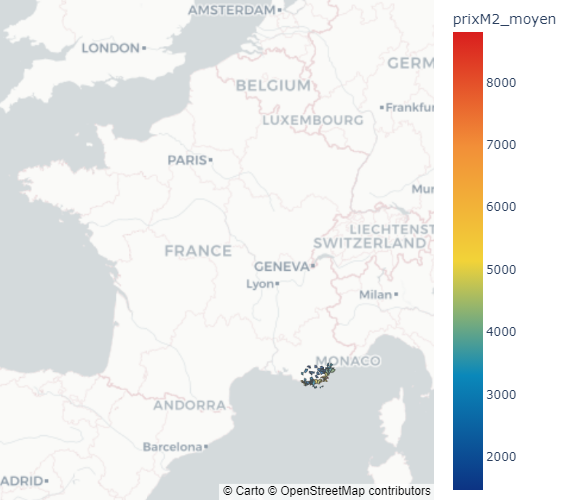

In [103]:
##Affichage
import plotly.express as px # pip install plotly
figdep = px.choropleth_mapbox(tcd_typelocal, 
                                 geojson=responseCommune,
                                 color="prixM2_moyen",
                                 locations="code_commune",
                                 featureidkey="properties.code",
                                 color_continuous_scale="portland",
                                 hover_data =["nom_commune","Nb biens vendus"],
                                 opacity=0.7
                                )

figdep.update_layout(
        mapbox_center={"lat": 46.603354, "lon": 2.575065},  # Centrez la carte sur la France
        mapbox = {'style': "carto-positron",'zoom' : 4.25}, # zoom et style de la carte
        margin = {'l':0, 'r':0, 'b':0, 't':0},
        height= 500, # Taille de la figure
    )
figdep.show()

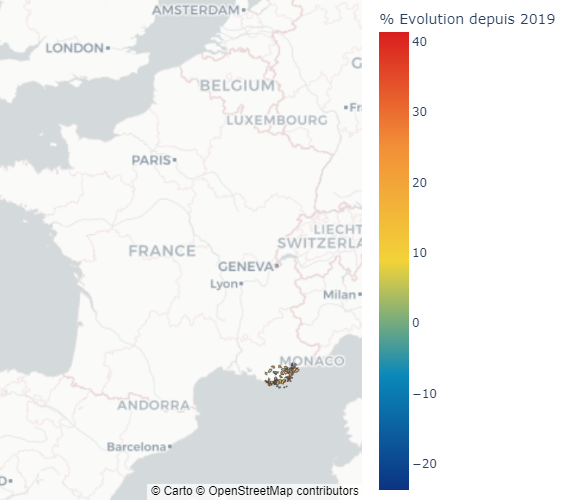

In [104]:
##Affichage % Evolution depuis 2019
import plotly.express as px
figdep = px.choropleth_mapbox(tcd_typelocal, 
                                 geojson=responseCommune,
                                 color="% Evolution depuis 2019",
                                 locations="code_commune",
                                 featureidkey="properties.code",
                                 color_continuous_scale="portland",
                                 hover_data =["nom_commune","Nb biens vendus"],
                                 opacity=0.7
                                )

figdep.update_layout(
        mapbox_center={"lat": 46.603354, "lon": 2.575065},  # Centrez la carte sur la France
        mapbox = {'style': "carto-positron",'zoom' : 4.25}, # zoom et style de la carte
        margin = {'l':0, 'r':0, 'b':0, 't':0},
        height= 500, # Taille de la figure
    )
figdep.show()

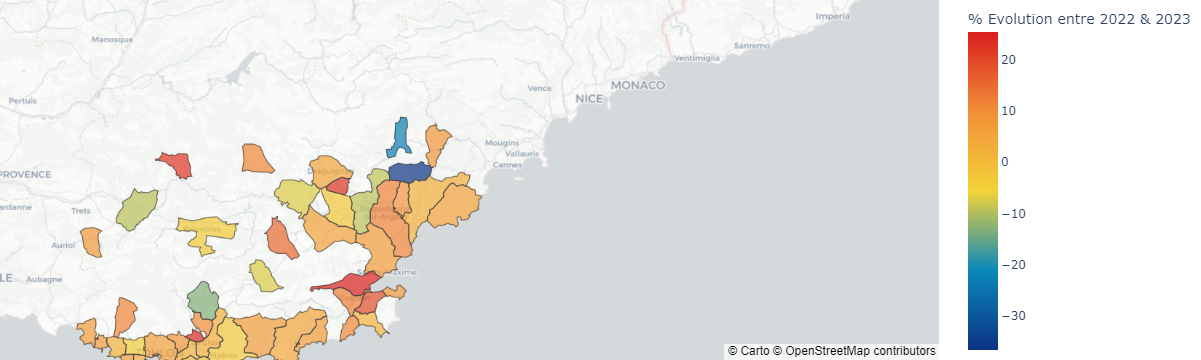

In [106]:
##Affichage % Evolution entre 2022 & 2023
import plotly.express as px
figdep = px.choropleth_mapbox(tcd_typelocal, 
                                 geojson=responseCommune,
                                 color="% Evolution entre 2022 & 2023",
                                 locations="code_commune",
                                 featureidkey="properties.code",
                                 color_continuous_scale="portland",
                                 hover_data =["nom_commune"],
                                 opacity=0.7
                                )

figdep.update_layout(
        mapbox_center={"lat": 46.603354, "lon": 2.575065},  # Centrez la carte sur la France
        mapbox = {'style': "carto-positron",'zoom' : 4.25}, # zoom et style de la carte
        margin = {'l':0, 'r':0, 'b':0, 't':0},
        height= 500, # Taille de la figure
    )
figdep.show()

In [105]:
EvolutionPrixM20232022dep = ((tcd_typelocal["Nb biens vendus"]*tcd_typelocal["% Evolution entre 2022 & 2023"]).sum())/(tcd_typelocal["Nb biens vendus"].sum())
print(EvolutionPrixM20232022dep)

4.949604520316321


In [79]:
tcd_typelocal

annee               nom_commune code_commune       2019_x       2020_x  \
2                           Apt        84003  1021.952259  1048.705243   
5                       Avignon        84007  2050.000000  2141.428571   
9                       Bollène        84019  1050.000000  1303.191489   
15                      Cadenet        84026  3142.857143  2799.872123   
20                   Carpentras        84031  1609.482759  1612.955466   
22                    Cavaillon        84035  1673.469388  1761.982571   
29     Entraigues-sur-la-Sorgue        84043  2015.750916  2163.879599   
39         L'Isle-sur-la-Sorgue        84054  2788.461538  2866.037736   
50                    Le Pontet        84092  1590.909091  1568.888889   
61                      Monteux        84080  2040.000000  2233.333333   
62         Morières-lès-Avignon        84081  2284.259259  2269.003322   
68                       Orange        84087  1569.758065  1615.384615   
70                      Pertuis        84089  2513.846154  2637.931034   
97                      Sorgues        84129  1387.751827  1395.238095   
104           Vaison-la-Romaine        84137  2505.376344  2494.755245   
105                     Valréas        84138   995.458744  1055.316092   

annee       2021_x       2022_x       2023_x  prixM2_moyen  2019_y  2020_y  \
2      1264.705882  1325.250836  1646.518375   1261.426519      62      92   
5      2166.111111  2285.714286  2315.073529   2191.665500    1275    1208   
9      1189.931350  1393.750000  1306.980057   1248.770579      27      35   
15     2760.869565  2656.250000  3405.952381   2953.160242      43      24   
20     1675.000000  1711.309524  1600.000000   1641.749550     191     214   
22     1797.435897  2067.091454  2194.035853   1898.803033     171     194   
29     2410.041408  2327.272727  2125.454545   2208.479839      30      26   
39     2876.923077  3174.603175  3529.411765   3047.087458     163     125   
50     1705.128205  1869.709816  1854.166667   1717.760534     103     134   
61     2321.033654  2428.854167  2545.350172   2313.714265      39      49   
62     2365.853659  2483.870968  2211.111111   2322.819664      23      30   
68     1615.384615  1739.267677  1780.739599   1664.106914     166     185   
70     2631.578947  2810.234848  3137.972689   2746.312735     165     163   
97     1453.333333  1639.701493  1852.813299   1545.767610      98      83   
104    2325.581395  2539.682540  2954.678363   2564.014777      41      34   
105     918.750000  1079.365079  1130.400000   1035.857983      34      34   

annee  2021_y  2022_y  2023_y  Nb biens vendus  % Evolution depuis 2019  \
2         101     108      34              397                37.932532   
5        1337    1369     660             5849                11.449897   
9          44      46      20              172                19.662125   
15         23      26      11              127                 7.724572   
20        229     216      91              941                -0.592672   
22        210     198      90              863                23.726434   
29         24      41      11              132                 5.161420   
39        127     131      57              603                20.993590   
50        163     162      55              617                14.198161   
61         56      71      18              233                19.853857   
62         25      35      19              132                -3.308208   
68        183     206      82              822                11.847972   
70        201     169      84              782                19.889483   
97         95     111      32              419                25.100288   
104        35      35      13              158                15.206461   
105        29      37      15              149                11.937478   

annee  % Evolution entre 2022 & 2023  
2                          24.242017  
5                           1.284467  
9                    